## Module 4 — Therapeutic Area Dynamics & Growth (2015–2025)

Counts file: ../data/processed/therapeutic_area_counts_2015_2025_sample.csv
Global totals file: ../data/processed/global_trials_totalcount_by_year_2015_2025.csv

Years in counts: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Number of therapeutic areas: 32

Sampled trials (Module 3): 54,907
Total trials 2015–2025 (Module 1): 382,630
Coverage ≈ 14.35% of all trials

Top 10 areas by increase in share (2015–2025):
                                         CAGR_pct  ShareChange_pp
Digital Health / AI / Technology              4.2            2.71
Neurology/Psychiatry                          2.4            2.20
Musculoskeletal / Orthopedic                  3.4            1.67
Behavioral / Psychological Health             7.9            1.30
Pain / Rehabilitation / Quality of Life       2.0            0.69
Sports / Exercise Medicine                    6.6            0.32
Geriatrics / Aging                            8.1            0.26
Sleep / Fatigue / Circadian         

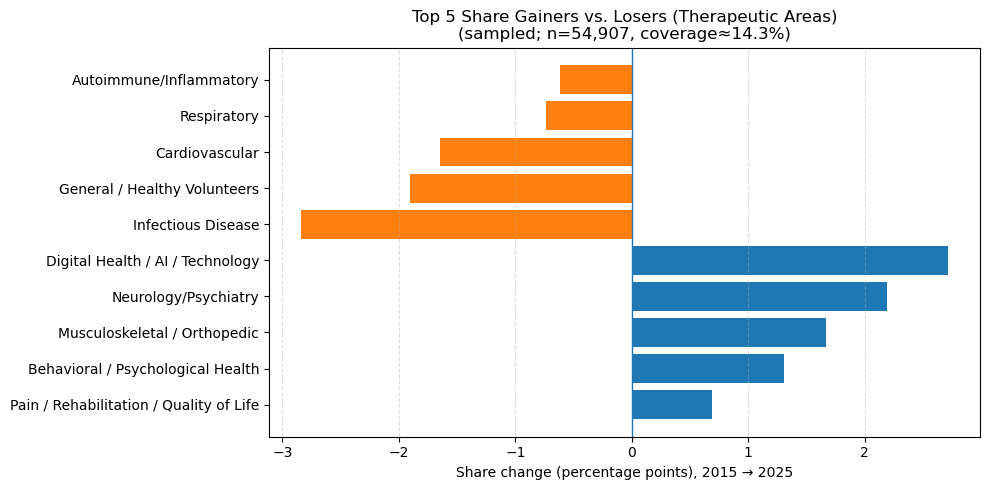


Saved figure: ../figures/module4_share_change_top5_up_down_2015_2025.png

Volatility ranking (std of yearly share %, 2015–2025) - Top 10:
TherapeuticArea
Infectious Disease                  2.67
Neurology/Psychiatry                0.85
Digital Health / AI / Technology    0.77
Metabolic/Endocrine                 0.72
Musculoskeletal / Orthopedic        0.63
Oncology                            0.63
General / Healthy Volunteers        0.54
Other                               0.52
Cardiovascular                      0.51
Respiratory                         0.39
Name: ShareStd_2015_2025, dtype: float64
Saved volatility table to: ../data/processed/module4_volatility_ranking_2015_2025.csv

Max YoY share jump (absolute pp), 2015–2025 - Top 10:
                                         MaxAbsYoYJump_pp_2015_2025  \
TherapeuticArea                                                       
Infectious Disease                                             7.97   
Oncology                                

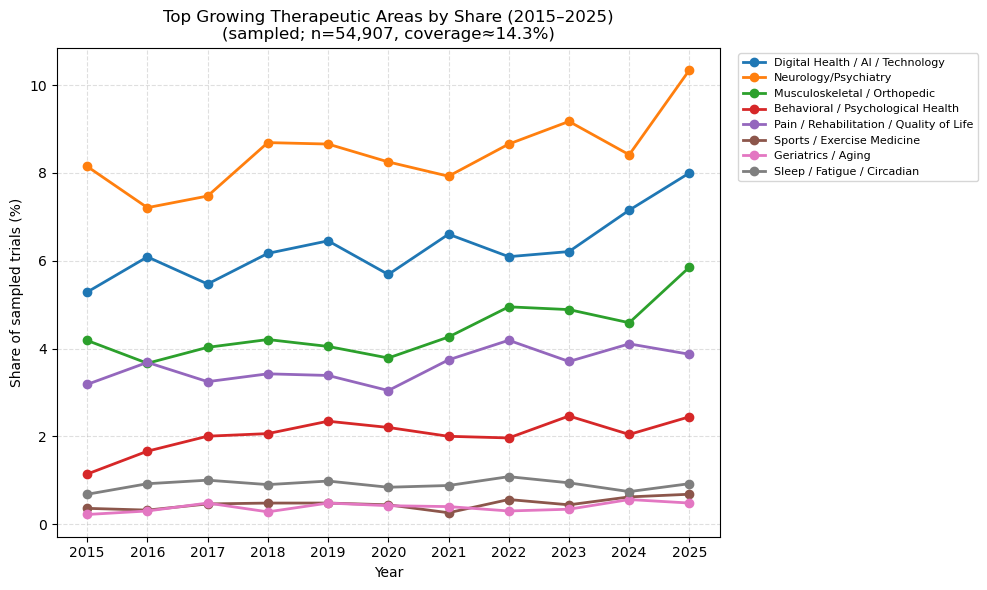


Saved top-growing areas line chart to: ../figures/module4_top_growing_areas_share_2015_2025.png

Summary notes for Module 4:
- Growth metrics are computed using 2015–2025 (CAGR and share change).
- Share change chart shows Top 5 winners/losers (percentage-point changes from 2015 to 2025).
- Volatility ranks areas by standard deviation of yearly share (2015–2025).
- Max YoY jump finds the largest absolute year-over-year share shift (2015–2025).
- Sample covers ≈14.3% of all ClinicalTrials.gov registrations in 2015–2025 (n=54,907).


In [2]:
"""
Module 4 — Therapeutic Area Dynamics & Growth (2015–2025, sampled)

Goal
-----
Use the yearly therapeutic area counts from Module 3 to:
1) Quantify how each therapeutic area changes over time (2015–2025).
2) Identify areas that are growing, declining, or volatile.
3) Visualize:
   - Top 5 share increase vs. Top 5 share decrease (2015 -> 2025)
   - Line chart for top-growing areas by share
   - (No heatmap; no concentration/HHI per request)

Notes
-----
- Data source:
  Module 3 output: ../data/processed/therapeutic_area_counts_2015_2025_sample.csv
- Coverage is computed using Module 1 totals:
  ../data/processed/global_trials_totalcount_by_year_2015_2025.csv
- All growth metrics (CAGR, share change, volatility, YoY jumps) use 2015–2025.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
PROCESSED_DIR = "../data/processed"
FIG_DIR = "../figures"
os.makedirs(FIG_DIR, exist_ok=True)

counts_path = os.path.join(PROCESSED_DIR, "therapeutic_area_counts_2015_2025_sample.csv")
total_counts_path = os.path.join(PROCESSED_DIR, "global_trials_totalcount_by_year_2015_2025.csv")

print("Counts file:", counts_path)
print("Global totals file:", total_counts_path)

# -------------------------------------------------------------------
# Step 1: Load yearly therapeutic area counts and build matrices
# -------------------------------------------------------------------
df_counts = pd.read_csv(counts_path)

# Year × TherapeuticArea matrix (raw counts)
counts_pivot = (
    df_counts
    .pivot(index="Year", columns="TherapeuticArea", values="TrialCount")
    .fillna(0)
    .sort_index()
)

years_full = counts_pivot.index.tolist()
areas = counts_pivot.columns.tolist()

print("\nYears in counts:", years_full)
print("Number of therapeutic areas:", len(areas))

# Convert to yearly share (%) within the sampled trials for that year
share_pivot = counts_pivot.div(counts_pivot.sum(axis=1), axis=0) * 100.0

# -------------------------------------------------------------------
# Step 2: Compute sample coverage vs. all trials (2015–2025)
# -------------------------------------------------------------------
total_sampled = int(df_counts["TrialCount"].sum())

coverage_pct = np.nan
coverage_rounded = None
total_population = None

if os.path.exists(total_counts_path):
    df_tot = pd.read_csv(total_counts_path)
    df_tot_15_25 = df_tot.query("Year >= 2015 & Year <= 2025")
    total_population = int(df_tot_15_25["TrialCount"].sum())
    coverage_pct = 100.0 * total_sampled / total_population if total_population > 0 else np.nan
    coverage_rounded = int(round(coverage_pct)) if np.isfinite(coverage_pct) else None

print(f"\nSampled trials (Module 3): {total_sampled:,}")
if total_population is not None:
    print(f"Total trials 2015–2025 (Module 1): {total_population:,}")
    print(f"Coverage ≈ {coverage_pct:.2f}% of all trials")
else:
    print("Total trials file not found -> Coverage = NA")

coverage_str = f"{coverage_pct:.1f}%" if np.isfinite(coverage_pct) else "NA"

# -------------------------------------------------------------------
# Step 3: Growth metrics (2015–2025)
# -------------------------------------------------------------------
start_year = 2015
end_year = 2025
num_years = end_year - start_year  # number of 1-year steps

start_counts = counts_pivot.loc[start_year]
end_counts = counts_pivot.loc[end_year]

# CAGR: only compute where start_counts > 0 to avoid division by zero
mask_valid = start_counts > 0
cagr = pd.Series(np.nan, index=areas, name="CAGR_2015_2025")
cagr[mask_valid] = (end_counts[mask_valid] / start_counts[mask_valid]) ** (1 / num_years) - 1

# Share change (percentage points): 2015 -> 2025
start_share = share_pivot.loc[start_year]
end_share = share_pivot.loc[end_year]
share_change = (end_share - start_share).rename("ShareChange_2015_2025_pp")

growth_df = pd.concat([cagr, share_change], axis=1).sort_values("ShareChange_2015_2025_pp", ascending=False)

# Top 10 increases / decreases (console)
print("\nTop 10 areas by increase in share (2015–2025):")
print(
    growth_df.head(10)
    .assign(
        CAGR_pct=lambda d: (d["CAGR_2015_2025"] * 100).round(1),
        ShareChange_pp=lambda d: d["ShareChange_2015_2025_pp"].round(2),
    )[["CAGR_pct", "ShareChange_pp"]]
)

print("\nTop 10 areas by decrease in share (2015–2025):")
print(
    growth_df.tail(10)
    .assign(
        CAGR_pct=lambda d: (d["CAGR_2015_2025"] * 100).round(1),
        ShareChange_pp=lambda d: d["ShareChange_2015_2025_pp"].round(2),
    )[["CAGR_pct", "ShareChange_pp"]]
)

# Save growth table
growth_out = os.path.join(PROCESSED_DIR, "module4_growth_metrics_2015_2025.csv")
(
    growth_df
    .assign(CAGR_pct=(growth_df["CAGR_2015_2025"] * 100))
    .to_csv(growth_out)
)
print("\nSaved growth metrics table to:", growth_out)

# -------------------------------------------------------------------
# Step 4: NEW FIGURE — Top 5 up / Top 5 down in share (2015 -> 2025)
# -------------------------------------------------------------------
top5_up = share_change.sort_values(ascending=False).head(5)
top5_down = share_change.sort_values(ascending=True).head(5)

print("\nTop 5 increases in share (2015 -> 2025) [percentage points]:")
print(top5_up.round(2))

print("\nTop 5 decreases in share (2015 -> 2025) [percentage points]:")
print(top5_down.round(2))

fig, ax = plt.subplots(figsize=(10, 5))

# Plot up (positive)
ax.barh(top5_up.index[::-1], top5_up.values[::-1])
# Plot down (negative) on the same axis (below)
ax.barh(top5_down.index, top5_down.values)

ax.axvline(0, linewidth=1)
ax.set_xlabel("Share change (percentage points), 2015 → 2025")
ax.set_title(
    "Top 5 Share Gainers vs. Losers (Therapeutic Areas)\n"
    f"(sampled; n={total_sampled:,}, coverage≈{coverage_str})"
)
ax.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "module4_share_change_top5_up_down_2015_2025.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print("\nSaved figure:", fig_path)

# -------------------------------------------------------------------
# Step 5: Volatility ranking (std of yearly share %, 2015–2025)
# -------------------------------------------------------------------
volatility = share_pivot.std(axis=0).sort_values(ascending=False).rename("ShareStd_2015_2025")
vol_out = os.path.join(PROCESSED_DIR, "module4_volatility_ranking_2015_2025.csv")
volatility.to_csv(vol_out)

print("\nVolatility ranking (std of yearly share %, 2015–2025) - Top 10:")
print(volatility.head(10).round(2))

print("Saved volatility table to:", vol_out)

# -------------------------------------------------------------------
# Step 6: Max year-over-year share jump (absolute pp), 2015–2025
# -------------------------------------------------------------------
yoy_diff = share_pivot.diff(axis=0)  # Year-over-year change (pp)
max_abs_jump = yoy_diff.abs().max(axis=0).rename("MaxAbsYoYJump_pp_2015_2025")

# Which year had the max jump? (use idxmax on abs diff; the year corresponds to the "end year" of the diff)
year_of_max = yoy_diff.abs().idxmax(axis=0).rename("YearOfMaxJump")

jump_df = pd.concat([max_abs_jump, year_of_max], axis=1).sort_values("MaxAbsYoYJump_pp_2015_2025", ascending=False)

jump_out = os.path.join(PROCESSED_DIR, "module4_max_yoy_jump_2015_2025.csv")
jump_df.to_csv(jump_out)

print("\nMax YoY share jump (absolute pp), 2015–2025 - Top 10:")
print(jump_df.head(10).round(2))

print("\nSaved max YoY jump table to:", jump_out)

# -------------------------------------------------------------------
# Step 7: Line plot for top growing areas by share (2015–2025)
# -------------------------------------------------------------------
top_k = 8
top_areas = growth_df.head(top_k).index.tolist()

plt.figure(figsize=(10, 6))
for area in top_areas:
    plt.plot(
        share_pivot.index,
        share_pivot[area],
        marker="o",
        linewidth=2,
        label=area,
    )

plt.xticks(share_pivot.index, [str(y) for y in share_pivot.index], rotation=0)
plt.ylabel("Share of sampled trials (%)")
plt.xlabel("Year")
plt.title(
    "Top Growing Therapeutic Areas by Share (2015–2025)\n"
    f"(sampled; n={total_sampled:,}, coverage≈{coverage_str})"
)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
plt.tight_layout()

line_fig_path = os.path.join(FIG_DIR, "module4_top_growing_areas_share_2015_2025.png")
plt.savefig(line_fig_path, dpi=300)
plt.show()
print("\nSaved top-growing areas line chart to:", line_fig_path)

# -------------------------------------------------------------------
# Step 8: Summary
# -------------------------------------------------------------------
print("\nSummary notes for Module 4:")
print("- Growth metrics are computed using 2015–2025 (CAGR and share change).")
print("- Share change chart shows Top 5 winners/losers (percentage-point changes from 2015 to 2025).")
print("- Volatility ranks areas by standard deviation of yearly share (2015–2025).")
print("- Max YoY jump finds the largest absolute year-over-year share shift (2015–2025).")
print(f"- Sample covers ≈{coverage_str} of all ClinicalTrials.gov registrations in 2015–2025 (n={total_sampled:,}).")
